In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# 1. Load the data
data = pd.read_csv("vendas_sorveteria.csv")

# 2. Basic data information
print("Basic information:")
print(data.info())

print("\nDescriptive statistics:")
print(data.describe().transpose())

# Check for missing values
data.dropna(inplace=True)

Basic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        365 non-null    object 
 1   temp        365 non-null    float64
 2   week_day    365 non-null    object 
 3   holiday     365 non-null    bool   
 4   event       365 non-null    bool   
 5   strawberry  365 non-null    int64  
 6   chocolate   365 non-null    int64  
 7   lemon       365 non-null    int64  
 8   grape       365 non-null    int64  
 9   mango       365 non-null    int64  
 10  total       365 non-null    int64  
dtypes: bool(2), float64(1), int64(6), object(2)
memory usage: 26.5+ KB
None

Descriptive statistics:
            count        mean        std    min    25%    50%    75%    max
temp        365.0   31.274521   3.841243   25.0   27.9   31.0   34.7   38.0
strawberry  365.0  112.726027  13.350989   84.0  103.0  113.0  121.0  168.0
chocolate   3

## Análise Preliminar dos Dados

A etapa inicial deste projeto envolveu uma análise detalhada do conjunto de dados fornecido pela Gelato Mágico. Observações importantes foram identificadas:

1.  **Restrição de Sabores:**
    * O portfólio de produtos da Gelato Mágico é composto por cinco sabores de sorvete: morango, chocolate, limão, uva e manga. Esta informação é crucial para a modelagem das vendas por sabor e para a gestão de estoque.

2.  **Intervalo de Dados:**
    * O conjunto de dados abrange o período de um ano, fornecendo um panorama de vendas ao longo do ano de 2023. Esse período inclui variação de estações climáticas, oque pode ser muito valioso para o modelo.

3.  **Operação Diária:**
    * A Gelato Mágico opera diariamente, o que simplifica a análise temporal, mas exige atenção para a identificação de padrões de vendas relacionados aos dias da semana e feriados.

4.  **Variáveis Relevantes:**
    * Além das vendas por sabor, os dados incluem variáveis como temperatura diária, indicação de feriados e eventos especiais. Estas variáveis serão fundamentais para a construção de um modelo preditivo robusto.

Após gerar o resumo dos dados selecionados, percebemos que:

* A média da temperatura é de 31ºC
* A média de vendas é de 389 sorvetes ao dia;
* A menor e a maior temperatura é de 25ºC e 38ºC respectivamente;
* O menor e o maior número de vendas é 296 e 565 sorvetes respesctivamente;

### Selecionando os Dados

In [55]:
# Convert temperature to integer
data["temp"] = data["temp"].astype(int)

# Selecting relevant columns
df = data[["temp", "holiday", "event", "strawberry", "chocolate", "lemon", "grape", "mango", "total"]]

# Encoding categorical variables
df = pd.get_dummies(df, columns=["holiday", "event"], drop_first=True)

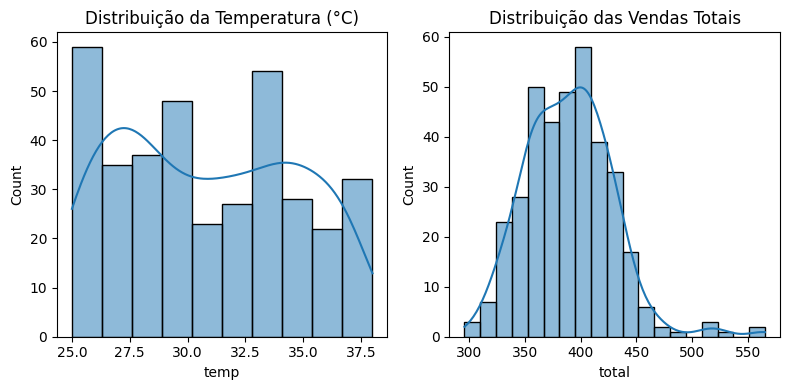

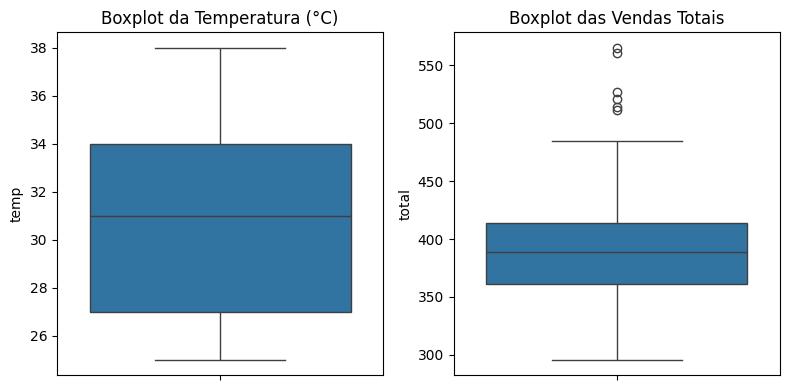

In [58]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.histplot(df['temp'], kde=True)
plt.title('Distribuição da Temperatura (°C)')

plt.subplot(1, 2, 2)
sns.histplot(df['total'], kde=True)
plt.title('Distribuição das Vendas Totais')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['temp'])
plt.title('Boxplot da Temperatura (°C)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['total'])
plt.title('Boxplot das Vendas Totais')

plt.tight_layout()
plt.show()

### Análise dos Dados

* A temperatura varia em uma faixa relativamente estreita, aproximadamente de 25°C a 38°C, o que é esperado em uma região com clima relativamente estável.
* Há uma leve assimetria à direita na distribuição, indicando que temperaturas mais altas são menos frequentes, mas ainda ocorrem.
* A maioria dos dias tem temperaturas entre 28ºC e 35ºC.
* A caixa se estende de aproximadamente 360 a 420 unidades. Isso indica que a maioria dos dias tem vendas totais nesse intervalo.
* Existem vários outliers acima do bigode superior. Esses outliers representam dias com vendas totais excepcionalmente altas, que podem ser devidos a eventos especiais, feriados ou condições climáticas extremas. Esses outliers podem influenciar a média e a variabilidade das vendas totais.

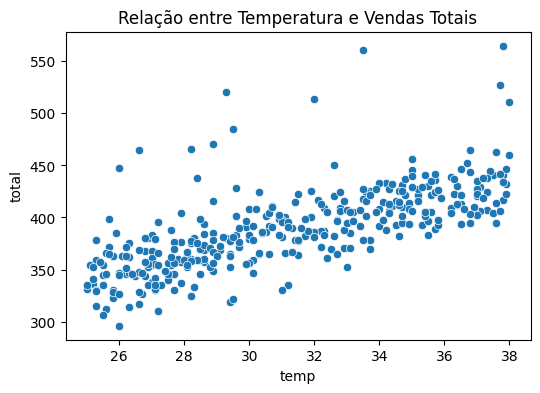


Correlação entre Temperatura e Vendas Totais:
           temp     total
temp   1.000000  0.701685
total  0.701685  1.000000


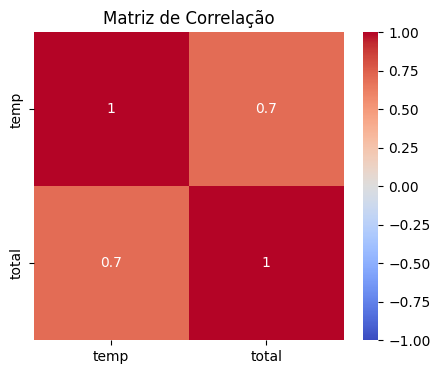

In [44]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='temp', y='total', data=df)
plt.title('Relação entre Temperatura e Vendas Totais')
plt.show()

correlation = df[['temp', 'total']].corr()
print("\nCorrelação entre Temperatura e Vendas Totais:")
print(correlation)

plt.figure(figsize=(5, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

* Há uma clara tendência de aumento nas vendas totais à medida que a temperatura sobe. Isso sugere uma correlação positiva entre as duas variáveis: dias mais quentes tendem a ter mais vendas de sorvete.
* A correlação positiva, embora presente, não é perfeita. Há bastante variação nas vendas para qualquer temperatura dada. Isso sugere que a temperatura é um preditor relevante, mas não o único, das vendas totais.
* A matriz de correlação confirma a relação positiva entre temperatura e vendas totais, indicando que temperaturas mais altas estão associadas a vendas mais elevadas.

## Preparação dos Dados

Não será necessário tratar dados ausentes ou outras transformações dos dados. Iremos somente dividir o conjunto de dados em conjuntos de treinamento e teste.

In [59]:
# Splitting features and target
X = df.drop(columns=["total", "strawberry", "chocolate", "lemon", "grape", "mango"])
y_total = df["total"].values

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Treinamento do Modelo

O modelo escolhido foi a Regressão Linear simples

In [60]:
# Train the model for total sales prediction
lr_total = LinearRegression()
lr_total.fit(X_train_scaled, y_train)

LinearRegression()

## Predição das Vendas

In [61]:
# Predictions for total sales
y_train_pred = lr_total.predict(X_train_scaled)
y_test_pred = lr_total.predict(X_test_scaled)

## Avaliar o Modelo

In [65]:
# Evaluation
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train R²: {r2_train:.2f}")
print(f"Test R²: {r2_test:.2f}")

Train MSE: 409.08
Test MSE: 384.02
Train R²: 0.74
Test R²: 0.73


## Análise dos Resultados

* Os erros estão próximos entre treino e teste → o modelo está generalizando bem.

* O modelo explica 73% da variação nas vendas no conjunto de teste. Isso indica uma boa relação entre as variáveis escolhidas e o total de vendas.

## Treinamento para Predição dos Sabores

In [66]:
# Train separate models for each flavor
flavors = ["strawberry", "chocolate", "lemon", "grape", "mango"]
flavor_models = {}

for flavor in flavors:
    y_flavor = df[flavor].values
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X, y_flavor, test_size=0.2, random_state=42)
    lr_flavor = LinearRegression()
    lr_flavor.fit(scaler.transform(X_train_f), y_train_f)
    flavor_models[flavor] = lr_flavor

# Function to predict total sales and individual flavors
def predict_sales(temp, holiday=False, event=False):
    temp = int(temp)  # Ensure temperature is an integer
    input_data = pd.DataFrame({"temp": [temp], "holiday_True": [int(holiday)], "event_True": [int(event)]})
    input_scaled = scaler.transform(input_data)
    total_sales = round(lr_total.predict(input_scaled)[0])
    
    flavor_predictions = {}
    for flavor, model in flavor_models.items():
        flavor_predictions[flavor] = round(model.predict(input_scaled)[0])
    
    return total_sales, flavor_predictions

## Exemplo de Uso

Predicted total sales for 30°C: 380
Predicted strawberry sales: 110
Predicted chocolate sales: 135
Predicted lemon sales: 50
Predicted grape sales: 39
Predicted mango sales: 46


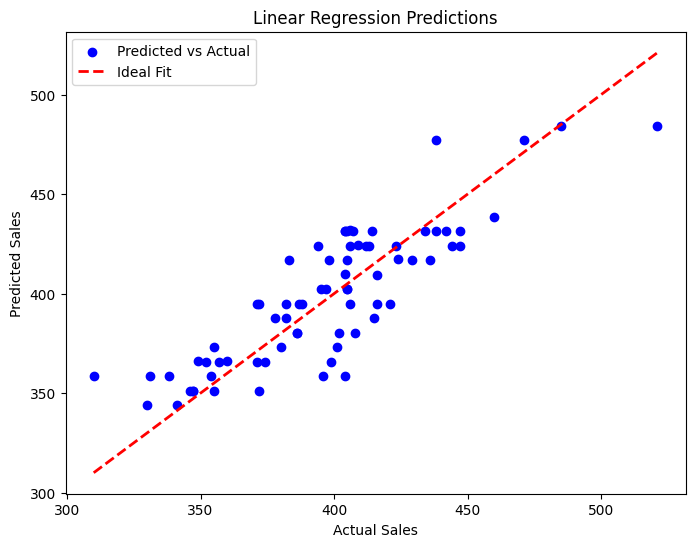

In [67]:
# Example usage
temp_input = 30
pred_total, pred_flavors = predict_sales(temp_input)
print(f"Predicted total sales for {temp_input}°C: {pred_total}")
for flavor, qty in pred_flavors.items():
    print(f"Predicted {flavor} sales: {qty}")

# Visualizing predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Linear Regression Predictions')
plt.legend()
plt.show()